In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import glob
import copy
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns

### Part I - Read in the Data

In [2]:
# specify on the path
path= '/Users/philhuang/Desktop/Phil_projects/P5_PhilHuang/workingdata/'

# read in each sub-dataset
file_2020q1_OH=pd.read_csv(path+'file_2020Q1_OH.csv')
file_2020q1_VA=pd.read_csv(path+'file_2020Q1_VA.csv')
file_2020q1_GA=pd.read_csv(path+'file_2020Q1_GA.csv')
file_2020q1_MI=pd.read_csv(path+'file_2020Q1_MI.csv')
file_2020q1_CO=pd.read_csv(path+'file_2020Q1_CO.csv')

# concat all dataframes
df_all=pd.concat([file_2020q1_OH, file_2020q1_VA, file_2020q1_GA, file_2020q1_MI, file_2020q1_CO])

# check the data
print('Total number of obs:{0} \nNumber of unique loans:{1}'.format(len(df_all), df_all['LOAN_ID'].nunique()))

Total number of obs:2071611 
Number of unique loans:104924


In [3]:
# derive a variable for 'bad'.  
# This variable will not be used in clustering, but it will be used to validate clusters. 
df_all['bad'] = np.where(df_all['DLQ_STATUS'] >= 6, 1, 0)
df_bad        = df_all.groupby('LOAN_ID')['bad'].sum().reset_index()
df_bad['bad'] = np.where(df_bad['bad'] > 0, 1, 0)

In [4]:
# drop duplicated loans
df = df_all.drop_duplicates(subset='LOAN_ID', keep='first')

In [5]:
# merge the loan dataset with no duplicates and the bad loan dummy together.
df = pd.merge(df.drop('bad', axis=1), df_bad, on="LOAN_ID", how='inner')

In [6]:
# Take out the column list.
column_lst = df.columns.tolist()

In [7]:
# check the bad rate
df['bad'].mean()

0.02353131790629408

### Part 2 - Determine what columns to use for generating clusters
* Kmeans is based on euclidean distance, so only numeric values can be used. 
* some character varibales can be transformed to numeric varlues. 

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104924 entries, 0 to 104923
Columns: 109 entries, POOL_ID to bad
dtypes: float64(75), int64(12), object(22)
memory usage: 88.1+ MB


In [9]:
# get some descriptive statistics for numeric values 
# Transpose the output for a easier viewing
df.describe().T

count          mean            std           min  \
POOL_ID               0.0           NaN            NaN           NaN   
LOAN_ID          104924.0  9.917922e+07  197019.945107  9.883674e+07   
ACT_PERIOD       104924.0  2.306123e+04    8365.196512  1.202000e+04   
MASTER_SERVICER       0.0           NaN            NaN           NaN   
ORIG_RATE        104924.0  3.808843e+00       0.451864  2.375000e+00   
...                   ...           ...            ...           ...   
PLAN_NUMBER           0.0           NaN            NaN           NaN   
DEAL_NAME             0.0           NaN            NaN           NaN   
ADR_COUNT             0.0           NaN            NaN           NaN   
ADR_UPB               0.0           NaN            NaN           NaN   
bad              104924.0  2.353132e-02       0.151584  0.000000e+00   

                         25%          50%           75%         max  
POOL_ID                  NaN          NaN           NaN         NaN  
LOAN_ID          99009455.75  99180553.50  9.934903e+07  99520476.0  
ACT_PERIOD          12020.00     22020.00  3.202000e+04     32020.0  
MASTER_SERVICER          NaN          NaN           NaN         NaN  
ORIG_RATE               3.50         3.75  3.999000e+00         6.5  
...                      ...          ...           ...         ...  
PLAN_NUMBER              NaN          NaN           NaN         NaN  
DEAL_NAME                NaN          NaN           NaN         NaN  
ADR_COUNT                NaN          NaN           NaN         NaN  
ADR_UPB                  NaN          NaN           NaN         NaN  
bad                     0.00         0.00  0.000000e+00         1.0  

[87 rows x 8 columns]

In [10]:
# check null values to see whether any cleaning needs to be done
pd.DataFrame(df.isnull().sum(), columns=['num'])

num
POOL_ID        104924
LOAN_ID             0
ACT_PERIOD          0
CHANNEL             0
SELLER              0
...               ...
RE_PROCS_FLAG  104924
ADR_TYPE            0
ADR_COUNT      104924
ADR_UPB        104924
bad                 0

[109 rows x 1 columns]

In [11]:
# Look at the type of the property type.
df['PROP'].value_counts()

SF    60598
PU    32909
CO    10748
MH      647
CP       22
Name: PROP, dtype: int64

In [12]:
# encode loan purpose
# we first combine these two types of property usages into 'other'
df['prop'] = np.where(df['PROP'].isin(['MH', 'CP']), 'other', df['PROP'])
df = pd.get_dummies(df, columns=['PURPOSE'])
df = pd.get_dummies(df, columns=['prop'])

In [13]:
# Since Kmeans is based on Euclidean distance, it only uses numeric values.
# Therefore, we only keep the numeric values
# Columns such as POOL_ID and LOAN_ID have no meaning in computation, so they are not included either.
# We keep LOAN_ID as a merging key to be used later.
# Decomissioned has the the same value for all rows, so it is dropped. 
# We delete Current Rate and current UPB. 
# OLTV（Original Loan to Value Ratio) and OCLTV (Original Combined Loan to Value Ratio) are too close to each other. 
# We retain OLTV only. 

# construct loan_term indicator. We care about whether they are 180 months, 360 months or others.
df['loan_term'] = np.where(df['ORIG_TERM']==360, 2, np.where(df['ORIG_TERM']==180, 1, 0))

# excclude those borrowers with no valid FICO
df = copy.deepcopy(df[df['CSCORE_B'] > 300])

# split the sample into 70% training set and 30% validation set.
np.random.seed(123)
df['random'] = np.random.uniform(0, 1, len(df['LOAN_ID']))
df['seg']    = np.where(df['random'] <= 0.7, 'mod', 'val')

# List of features we need to keep.
Xlist  = ['ORIG_UPB','CSCORE_B','loan_term','OLTV','DTI','NO_UNITS','MI_PCT','PURPOSE_C',
          'PURPOSE_P','PURPOSE_R','prop_CO','prop_PU','prop_SF','prop_other']
Xylist = ['ORIG_UPB','CSCORE_B','loan_term','OLTV','DTI','NO_UNITS','MI_PCT','PURPOSE_C',
          'PURPOSE_P','PURPOSE_R','prop_CO','prop_PU','prop_SF','prop_other','bad']

# keep the training set and validation set.
modelsample = copy.deepcopy(df[df['seg']=='mod'][Xylist].fillna(0))
valsample   = copy.deepcopy(df[df['seg']=='val'][Xylist].fillna(0))

#### All variables need to be standardized before running clustering

In [14]:
modelsample[Xlist].describe().T

count           mean            std      min       25%  \
ORIG_UPB    73302.0  253298.245614  123545.129939  12000.0  156000.0   
CSCORE_B    73302.0     756.711427      42.434717    620.0     729.0   
loan_term   73302.0       1.631565       0.672235      0.0       1.0   
OLTV        73302.0      73.866757      16.291012      7.0      65.0   
DTI         73302.0      34.156612       9.612269      0.0      27.0   
NO_UNITS    73302.0       1.010668       0.137093      1.0       1.0   
MI_PCT      73302.0       6.869840      11.679256      0.0       0.0   
PURPOSE_C   73302.0       0.254522       0.435595      0.0       0.0   
PURPOSE_P   73302.0       0.355311       0.478611      0.0       0.0   
PURPOSE_R   73302.0       0.390167       0.487791      0.0       0.0   
prop_CO     73302.0       0.102221       0.302941      0.0       0.0   
prop_PU     73302.0       0.313648       0.463978      0.0       0.0   
prop_SF     73302.0       0.577651       0.493937      0.0       0.0   
prop_other  73302.0       0.006480       0.080238      0.0       0.0   

                 50%       75%       max  
ORIG_UPB    236000.0  335000.0  800000.0  
CSCORE_B       766.0     791.0     832.0  
loan_term        2.0       2.0       2.0  
OLTV            76.0      85.0      97.0  
DTI             35.0      42.0      50.0  
NO_UNITS         1.0       1.0       4.0  
MI_PCT           0.0      12.0      35.0  
PURPOSE_C        0.0       1.0       1.0  
PURPOSE_P        0.0       1.0       1.0  
PURPOSE_R        0.0       1.0       1.0  
prop_CO          0.0       0.0       1.0  
prop_PU          0.0       1.0       1.0  
prop_SF          1.0       1.0       1.0  
prop_other       0.0       0.0       1.0

In [15]:
# normalize the variables
# It is very important to make a copy of the modeling sample and use the copy to calculate mean and std. 
    
# normalize the variable between 0 and 1  
modsamp = copy.deepcopy(modelsample)

# define a function to normalize the features
def scaler(x, samp):
    x_max = modsamp[x].max()
    x_min = modsamp[x].min()
    x_normalized=(samp[x]-x_min)/(x_max-x_min)
    return x_normalized

for item in Xlist:
    modelsample[item] = scaler(item, modelsample)
    valsample[item]   = scaler(item, valsample)

In [16]:
# check the training set
modelsample[Xlist].describe().T

count      mean       std  min       25%       50%       75%  \
ORIG_UPB    73302.0  0.306216  0.156783  0.0  0.182741  0.284264  0.409898   
CSCORE_B    73302.0  0.644865  0.200164  0.0  0.514151  0.688679  0.806604   
loan_term   73302.0  0.815783  0.336117  0.0  0.500000  1.000000  1.000000   
OLTV        73302.0  0.742964  0.181011  0.0  0.644444  0.766667  0.866667   
DTI         73302.0  0.683132  0.192245  0.0  0.540000  0.700000  0.840000   
NO_UNITS    73302.0  0.003556  0.045698  0.0  0.000000  0.000000  0.000000   
MI_PCT      73302.0  0.196281  0.333693  0.0  0.000000  0.000000  0.342857   
PURPOSE_C   73302.0  0.254522  0.435595  0.0  0.000000  0.000000  1.000000   
PURPOSE_P   73302.0  0.355311  0.478611  0.0  0.000000  0.000000  1.000000   
PURPOSE_R   73302.0  0.390167  0.487791  0.0  0.000000  0.000000  1.000000   
prop_CO     73302.0  0.102221  0.302941  0.0  0.000000  0.000000  0.000000   
prop_PU     73302.0  0.313648  0.463978  0.0  0.000000  0.000000  1.000000   
prop_SF     73302.0  0.577651  0.493937  0.0  0.000000  1.000000  1.000000   
prop_other  73302.0  0.006480  0.080238  0.0  0.000000  0.000000  0.000000   

            max  
ORIG_UPB    1.0  
CSCORE_B    1.0  
loan_term   1.0  
OLTV        1.0  
DTI         1.0  
NO_UNITS    1.0  
MI_PCT      1.0  
PURPOSE_C   1.0  
PURPOSE_P   1.0  
PURPOSE_R   1.0  
prop_CO     1.0  
prop_PU     1.0  
prop_SF     1.0  
prop_other  1.0

In [17]:
# check the validation set
valsample[Xlist].describe().T

count      mean       std       min       25%       50%  \
ORIG_UPB    31571.0  0.308121  0.157951 -0.002538  0.184010  0.286802   
CSCORE_B    31571.0  0.645665  0.199812  0.000000  0.514151  0.688679   
loan_term   31571.0  0.816794  0.336528  0.000000  0.500000  1.000000   
OLTV        31571.0  0.745215  0.179641  0.000000  0.644444  0.766667   
DTI         31571.0  0.683385  0.190090  0.060000  0.540000  0.700000   
NO_UNITS    31571.0  0.003716  0.045106  0.000000  0.000000  0.000000   
MI_PCT      31571.0  0.201033  0.336189  0.000000  0.000000  0.000000   
PURPOSE_C   31571.0  0.253207  0.434855  0.000000  0.000000  0.000000   
PURPOSE_P   31571.0  0.359000  0.479715  0.000000  0.000000  0.000000   
PURPOSE_R   31571.0  0.387793  0.487255  0.000000  0.000000  0.000000   
prop_CO     31571.0  0.102911  0.303847  0.000000  0.000000  0.000000   
prop_PU     31571.0  0.313864  0.464069  0.000000  0.000000  0.000000   
prop_SF     31571.0  0.577080  0.494031  0.000000  0.000000  1.000000   
prop_other  31571.0  0.006145  0.078149  0.000000  0.000000  0.000000   

                 75%       max  
ORIG_UPB    0.412437  0.956853  
CSCORE_B    0.806604  1.014151  
loan_term   1.000000  1.000000  
OLTV        0.866667  1.000000  
DTI         0.840000  1.000000  
NO_UNITS    0.000000  1.000000  
MI_PCT      0.342857  1.000000  
PURPOSE_C   1.000000  1.000000  
PURPOSE_P   1.000000  1.000000  
PURPOSE_R   1.000000  1.000000  
prop_CO     0.000000  1.000000  
prop_PU     1.000000  1.000000  
prop_SF     1.000000  1.000000  
prop_other  0.000000  1.000000

In [18]:
print("model sample avg bad: {}".format(modelsample['bad'].mean()))
print("validation sample avg bad: {}".format(valsample['bad'].mean()))
print("model sample total bad: {}".format(modelsample['bad'].sum()))
print("validation sample total bad: {}".format(valsample['bad'].sum()))

model sample avg bad: 0.023396360263021474
validation sample avg bad: 0.02388267714041367
model sample total bad: 1715
validation sample total bad: 754


In [19]:
# as our sample exceeds 2mm, it will take too long to process for some analysis. 
# We make a 2% sample for subsequent analyses. 
modelsample_good = modelsample[modelsample['bad']==0]
shrinksample     = pd.concat([modelsample_good.sample(1715), modelsample[modelsample['bad']==1]])
shrinksample.shape

(3430, 15)

In [20]:
shrinksample.describe().T

count      mean       std       min       25%       50%  \
ORIG_UPB    3430.0  0.323093  0.161535  0.010152  0.196701  0.305838   
CSCORE_B    3430.0  0.582637  0.218488  0.000000  0.424528  0.613208   
loan_term   3430.0  0.862828  0.297609  0.000000  1.000000  1.000000   
OLTV        3430.0  0.777094  0.175097  0.022222  0.688889  0.811111   
DTI         3430.0  0.729306  0.186769  0.060000  0.600000  0.760000   
NO_UNITS    3430.0  0.004373  0.051045  0.000000  0.000000  0.000000   
MI_PCT      3430.0  0.252545  0.362092  0.000000  0.000000  0.000000   
PURPOSE_C   3430.0  0.244606  0.429916  0.000000  0.000000  0.000000   
PURPOSE_P   3430.0  0.401458  0.490265  0.000000  0.000000  0.000000   
PURPOSE_R   3430.0  0.353936  0.478259  0.000000  0.000000  0.000000   
prop_CO     3430.0  0.101458  0.301978  0.000000  0.000000  0.000000   
prop_PU     3430.0  0.336443  0.472561  0.000000  0.000000  0.000000   
prop_SF     3430.0  0.559184  0.496557  0.000000  0.000000  1.000000   
prop_other  3430.0  0.002915  0.053924  0.000000  0.000000  0.000000   
bad         3430.0  0.500000  0.500073  0.000000  0.000000  0.500000   

                 75%       max  
ORIG_UPB    0.427665  0.956853  
CSCORE_B    0.764151  0.985849  
loan_term   1.000000  1.000000  
OLTV        0.922222  1.000000  
DTI         0.880000  1.000000  
NO_UNITS    0.000000  1.000000  
MI_PCT      0.714286  1.000000  
PURPOSE_C   0.000000  1.000000  
PURPOSE_P   1.000000  1.000000  
PURPOSE_R   1.000000  1.000000  
prop_CO     0.000000  1.000000  
prop_PU     1.000000  1.000000  
prop_SF     1.000000  1.000000  
prop_other  0.000000  1.000000  
bad         1.000000  1.000000

* We want to see whether 'bad' can be easily separated from 'good' in variable distribution
* If so, we do not need to go on. 

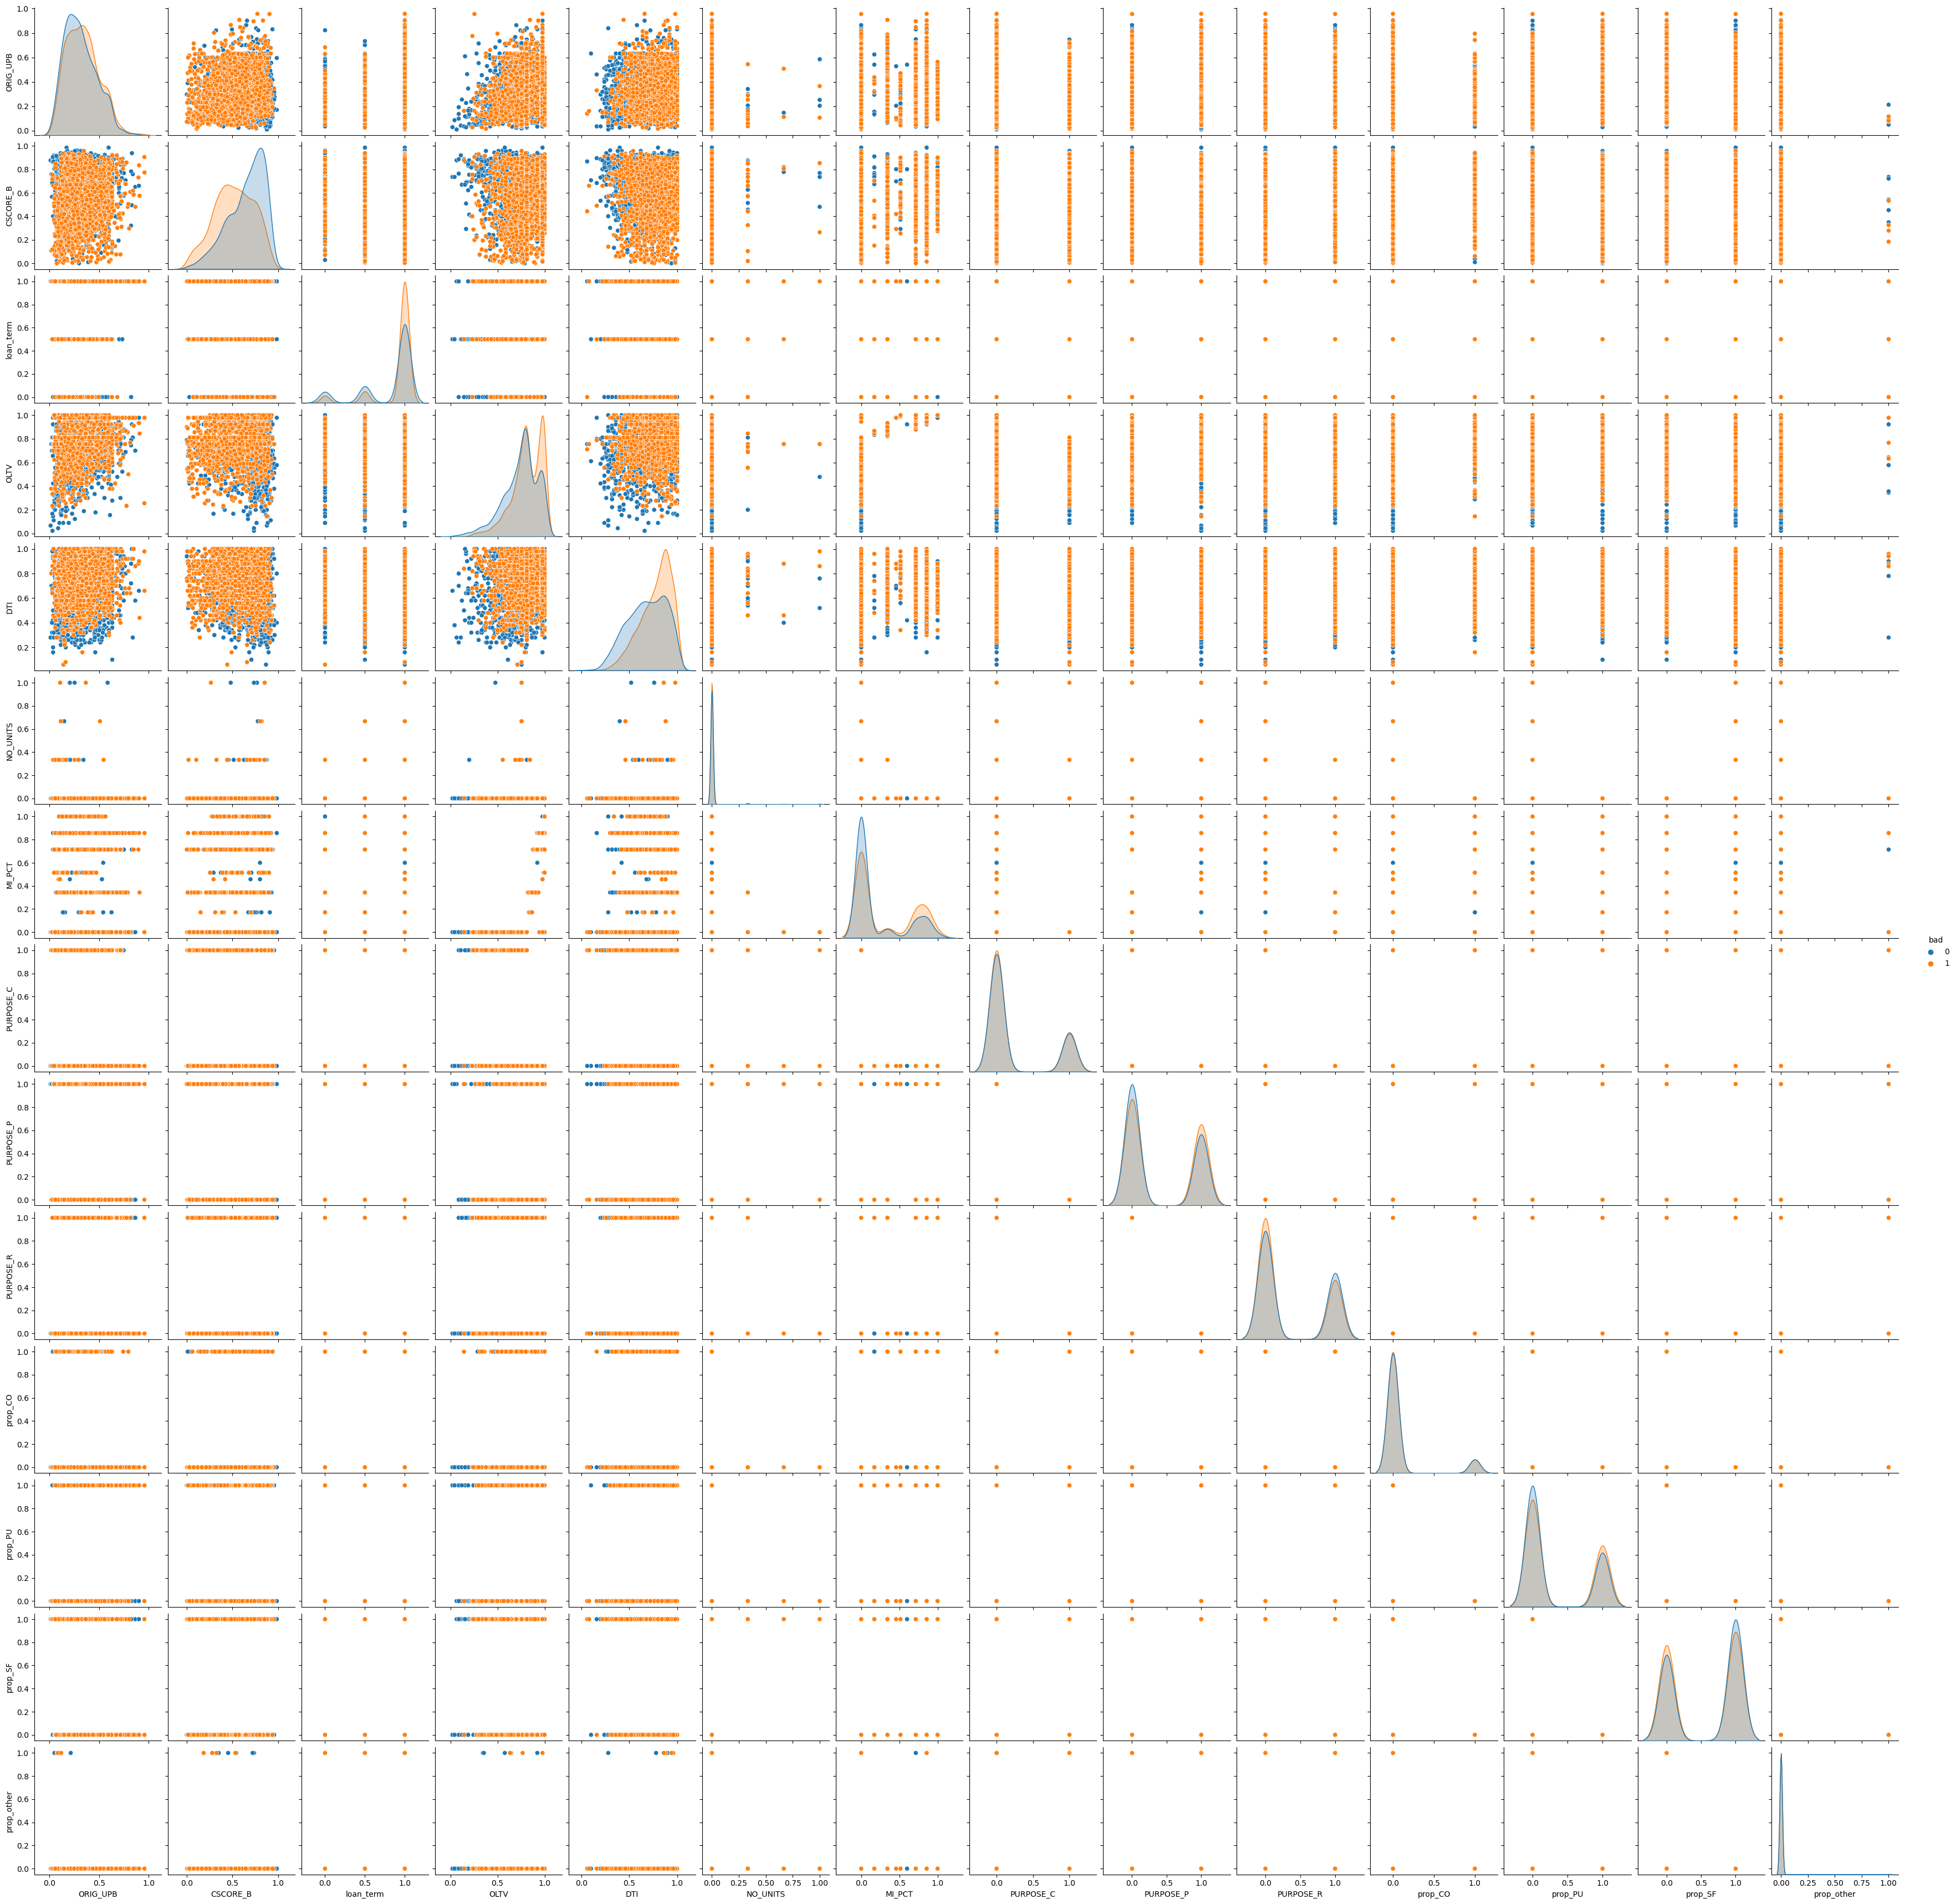

In [21]:
sns.pairplot(shrinksample, hue='bad')

#### determine optimal number of clusters (find the elbow point)

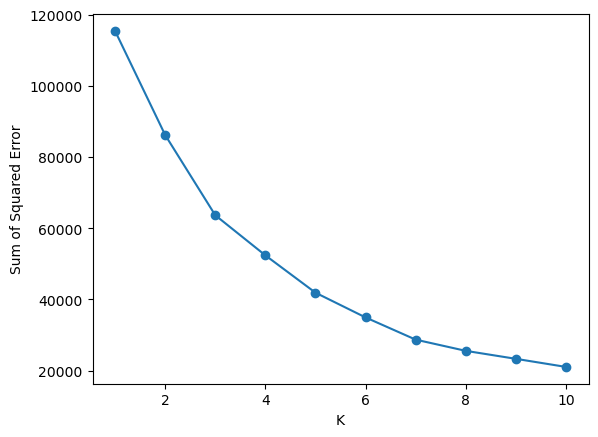

In [22]:
# deterine k value
# save the sse
sse=[]

# we set the cluster number to vary from 1 to 10
for k in range(1, 11):
    model = KMeans(n_clusters=k)
    model.fit(modelsample.drop('bad', axis=1))
    sse.append(model.inertia_)
    
x=range(1, 11)
y=sse

# plot the relationship between cluster number and the SSE
plt.xlabel('K')
plt.ylabel('Sum of Squared Error')
plt.plot(x, y, marker='o')

* We need to find a good elbow point in the above graph.
* It looks like SSE no longer drops significantly from 7 to 8. 

In [23]:
# we choose the cluster number to be 7
model=KMeans(n_clusters=7)
model.fit(modelsample.drop('bad', axis=1))

# make predictions
y_pred=model.predict(modelsample.drop('bad', axis=1))

# record the result of the prediction
modelsample['cluster']=y_pred

# calculate the total number of loans, total number of bad loans and the bad loan ratio of the training set
modelsample_sum=modelsample.groupby('cluster')['bad'].agg(model_count='count',
                                                          model_sum='sum',
                                                          model_mean='mean').reset_index()
# calculate the portion of each cluster
modelsample_sum['model_count_pct']=modelsample_sum['model_count']/(modelsample_sum['model_count'].sum())
modelsample_sum

cluster  model_count  model_sum  model_mean  model_count_pct
0        0         7493        172    0.022955         0.102221
1        1        13731        372    0.027092         0.187321
2        2        12395        260    0.020976         0.169095
3        3         9241        218    0.023591         0.126068
4        4        16673        287    0.017213         0.227456
5        5         8804        286    0.032485         0.120106
6        6         4965        120    0.024169         0.067733

In [24]:
# Check on the validation sample
y_pred_val = model.predict(valsample.drop('bad', axis=1))

# store the result of the clustering 
valsample['cluster'] = y_pred_val 

# calculate the total number of loans, total number of bad loans and the bad loan ratio of the validation set
valsample_sum=valsample.groupby('cluster')['bad'].agg(val_count='count',
                                                      val_sum='sum',
                                                      val_mean='mean').reset_index()

# calculate the portion of each cluster
valsample_sum['val_count_pct']=valsample_sum['val_count']/(valsample_sum['val_count'].sum())

valsample_sum

cluster  val_count  val_sum  val_mean  val_count_pct
0        0       3249       80  0.024623       0.102911
1        1       5998      166  0.027676       0.189984
2        2       5324      105  0.019722       0.168636
3        3       3959       79  0.019955       0.125400
4        4       7085      141  0.019901       0.224415
5        5       3825      136  0.035556       0.121155
6        6       2131       47  0.022055       0.067499

In [25]:
# merge the two summaries
mod_val_sum = pd.merge(modelsample_sum, valsample_sum, on='cluster', how='outer').reset_index()
mod_val_sum

index  cluster  model_count  model_sum  model_mean  model_count_pct  \
0      0        0         7493        172    0.022955         0.102221   
1      1        1        13731        372    0.027092         0.187321   
2      2        2        12395        260    0.020976         0.169095   
3      3        3         9241        218    0.023591         0.126068   
4      4        4        16673        287    0.017213         0.227456   
5      5        5         8804        286    0.032485         0.120106   
6      6        6         4965        120    0.024169         0.067733   

   val_count  val_sum  val_mean  val_count_pct  
0       3249       80  0.024623       0.102911  
1       5998      166  0.027676       0.189984  
2       5324      105  0.019722       0.168636  
3       3959       79  0.019955       0.125400  
4       7085      141  0.019901       0.224415  
5       3825      136  0.035556       0.121155  
6       2131       47  0.022055       0.067499

/var/folders/wp/k6ync4cd6vl262_wn1b0y6lc0000gn/T/ipykernel_16647/1086589039.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x:.1%}' for x in plt.gca().get_yticks()])


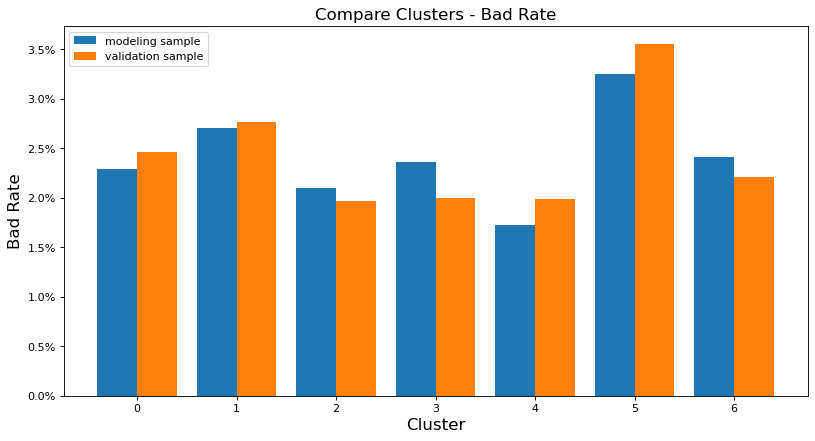

In [27]:
from matplotlib.pyplot import figure
import matplotlib.ticker as mtick  # for formating y axis

# visulize the results
figure(figsize=(12, 6), dpi=80)

clusters=[0, 1, 2, 3, 4, 5, 6]
x_axis=np.arange(len(clusters))

plt.bar(x_axis -0.2, mod_val_sum['model_mean'], width=0.4, label = 'modeling sample')
plt.bar(x_axis +0.2, mod_val_sum['val_mean'], width=0.4, label = 'validation sample')
plt.xticks(x_axis, clusters)
plt.xlabel("Cluster", fontsize=15)
plt.gca().set_yticklabels([f'{x:.1%}' for x in plt.gca().get_yticks()]) 
plt.ylabel("Bad Rate", fontsize=15, )
# plt.ylim([20, 80])  # we set this range from 20 in order to accentuate the difference between two periods
plt.title("Compare Clusters - Bad Rate", fontsize=15)
plt.legend(loc='best')
plt.show()

/var/folders/wp/k6ync4cd6vl262_wn1b0y6lc0000gn/T/ipykernel_16647/898776866.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x:.1%}' for x in plt.gca().get_yticks()])


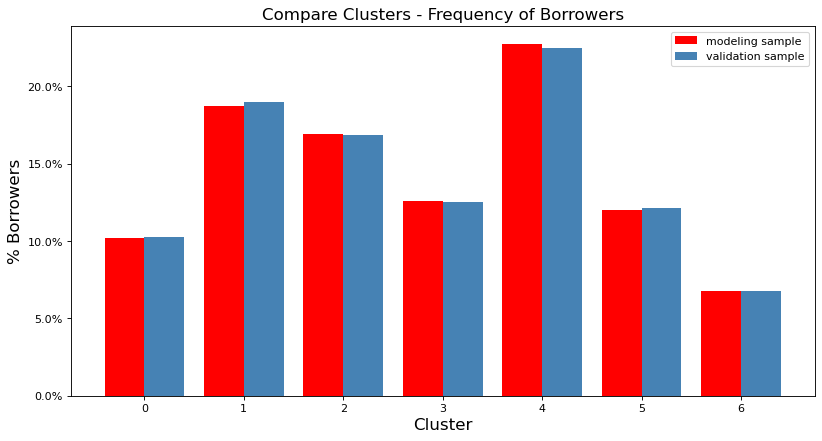

In [31]:
# compare the portion of each cluster in training and validation set
figure(figsize=(12, 6), dpi=80)

clusters=[0, 1, 2, 3, 4, 5, 6]
x_axis=np.arange(len(clusters))

plt.bar(x_axis -0.2, mod_val_sum['model_count_pct'], width=0.4, color='red', label = 'modeling sample')
plt.bar(x_axis +0.2, mod_val_sum['val_count_pct'], width=0.4, color='steelblue', label = 'validation sample')
plt.xticks(x_axis, clusters)
plt.xlabel("Cluster", fontsize=15)
plt.gca().set_yticklabels([f'{x:.1%}' for x in plt.gca().get_yticks()]) 
plt.ylabel("% Borrowers", fontsize=15, )
# plt.ylim([20, 80])  # we set this range from 20 in order to accentuate the difference between two periods
plt.title("Compare Clusters - Frequency of Borrowers", fontsize=15)
plt.legend(loc='best')

### Use clusters to assess performance 
* Even though Kmeans clustering is a method of unsupervised learning, we can use it to see whether clusters show any difference in predicting a target.

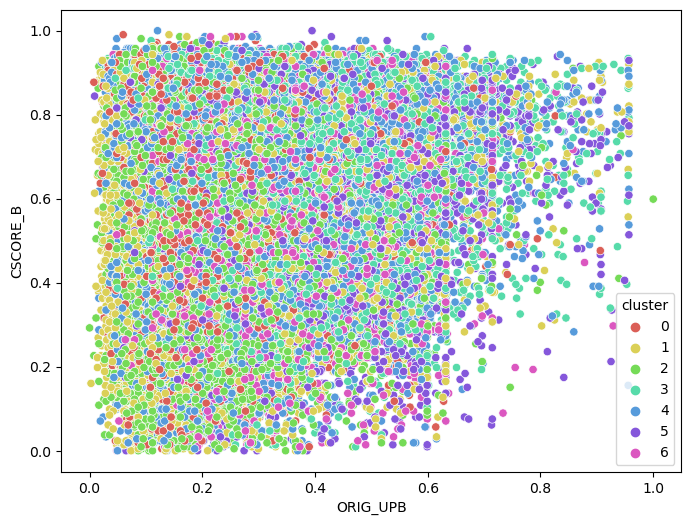

In [43]:
# Visualize clusters on variables
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax=sns.scatterplot(data = modelsample,
                   x=modelsample['ORIG_UPB'], y=modelsample['CSCORE_B'], 
                   hue=modelsample['cluster'], 
                   palette=sns.color_palette('hls', 7))

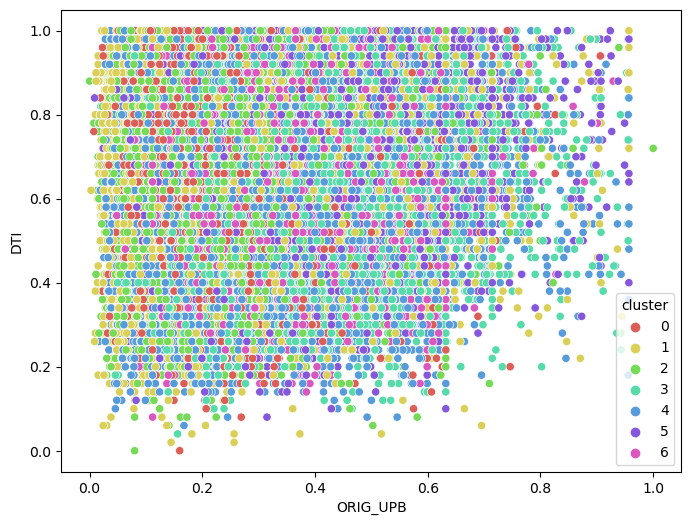

In [44]:
# Visualize clusters on variables
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax=sns.scatterplot(data = modelsample,
                   x=modelsample['ORIG_UPB'], y=modelsample['DTI'], 
                   hue=modelsample['cluster'], 
                   palette=sns.color_palette('hls', 7))

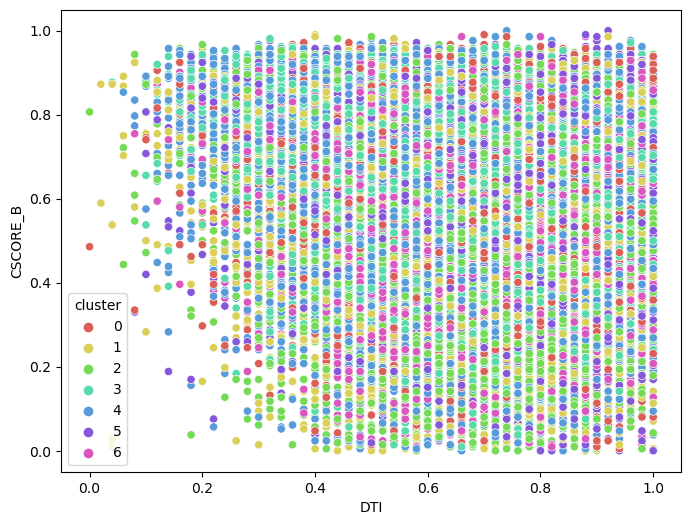

In [46]:
# Visualize clusters on variables
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax=sns.scatterplot(data = modelsample,
                   x=modelsample['DTI'], y=modelsample['CSCORE_B'], 
                   hue=modelsample['cluster'], 
                   palette=sns.color_palette('hls', 7))

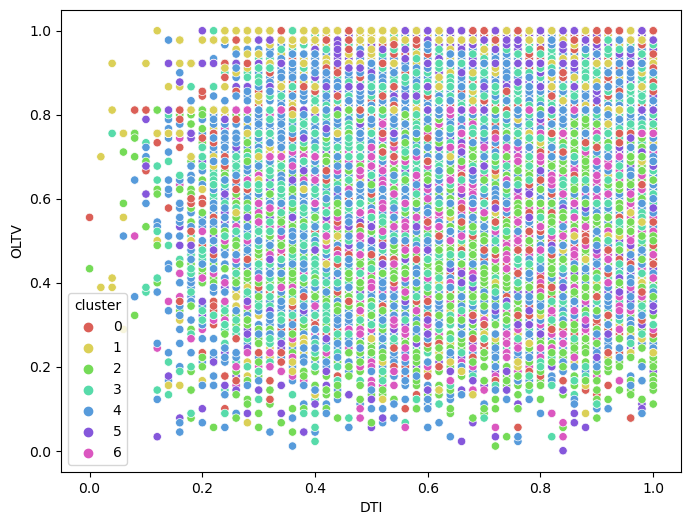

In [47]:
# Visualize clusters on variables
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax=sns.scatterplot(data = modelsample,
                   x=modelsample['DTI'], y=modelsample['OLTV'], 
                   hue=modelsample['cluster'], 
                   palette=sns.color_palette('hls', 7))

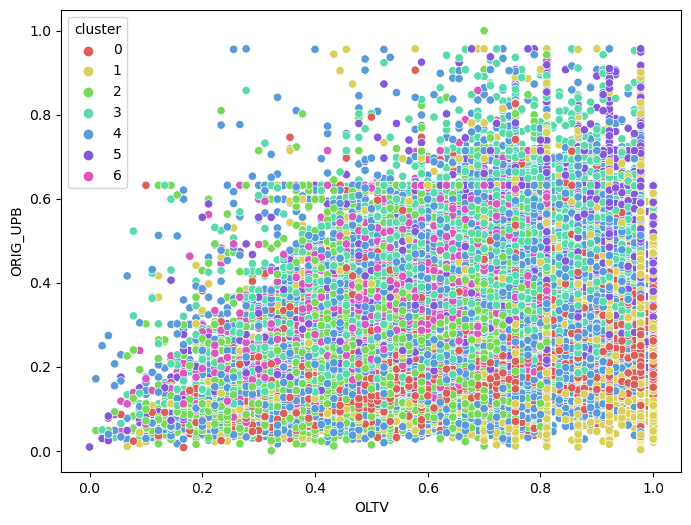

In [48]:
# Visualize clusters on variables
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax=sns.scatterplot(data = modelsample,
                   x=modelsample['OLTV'], y=modelsample['ORIG_UPB'], 
                   hue=modelsample['cluster'], 
                   palette=sns.color_palette('hls', 7))

#### We want to see whether the clusters can be easily seen in a 2-variable combition

(14495, 16)


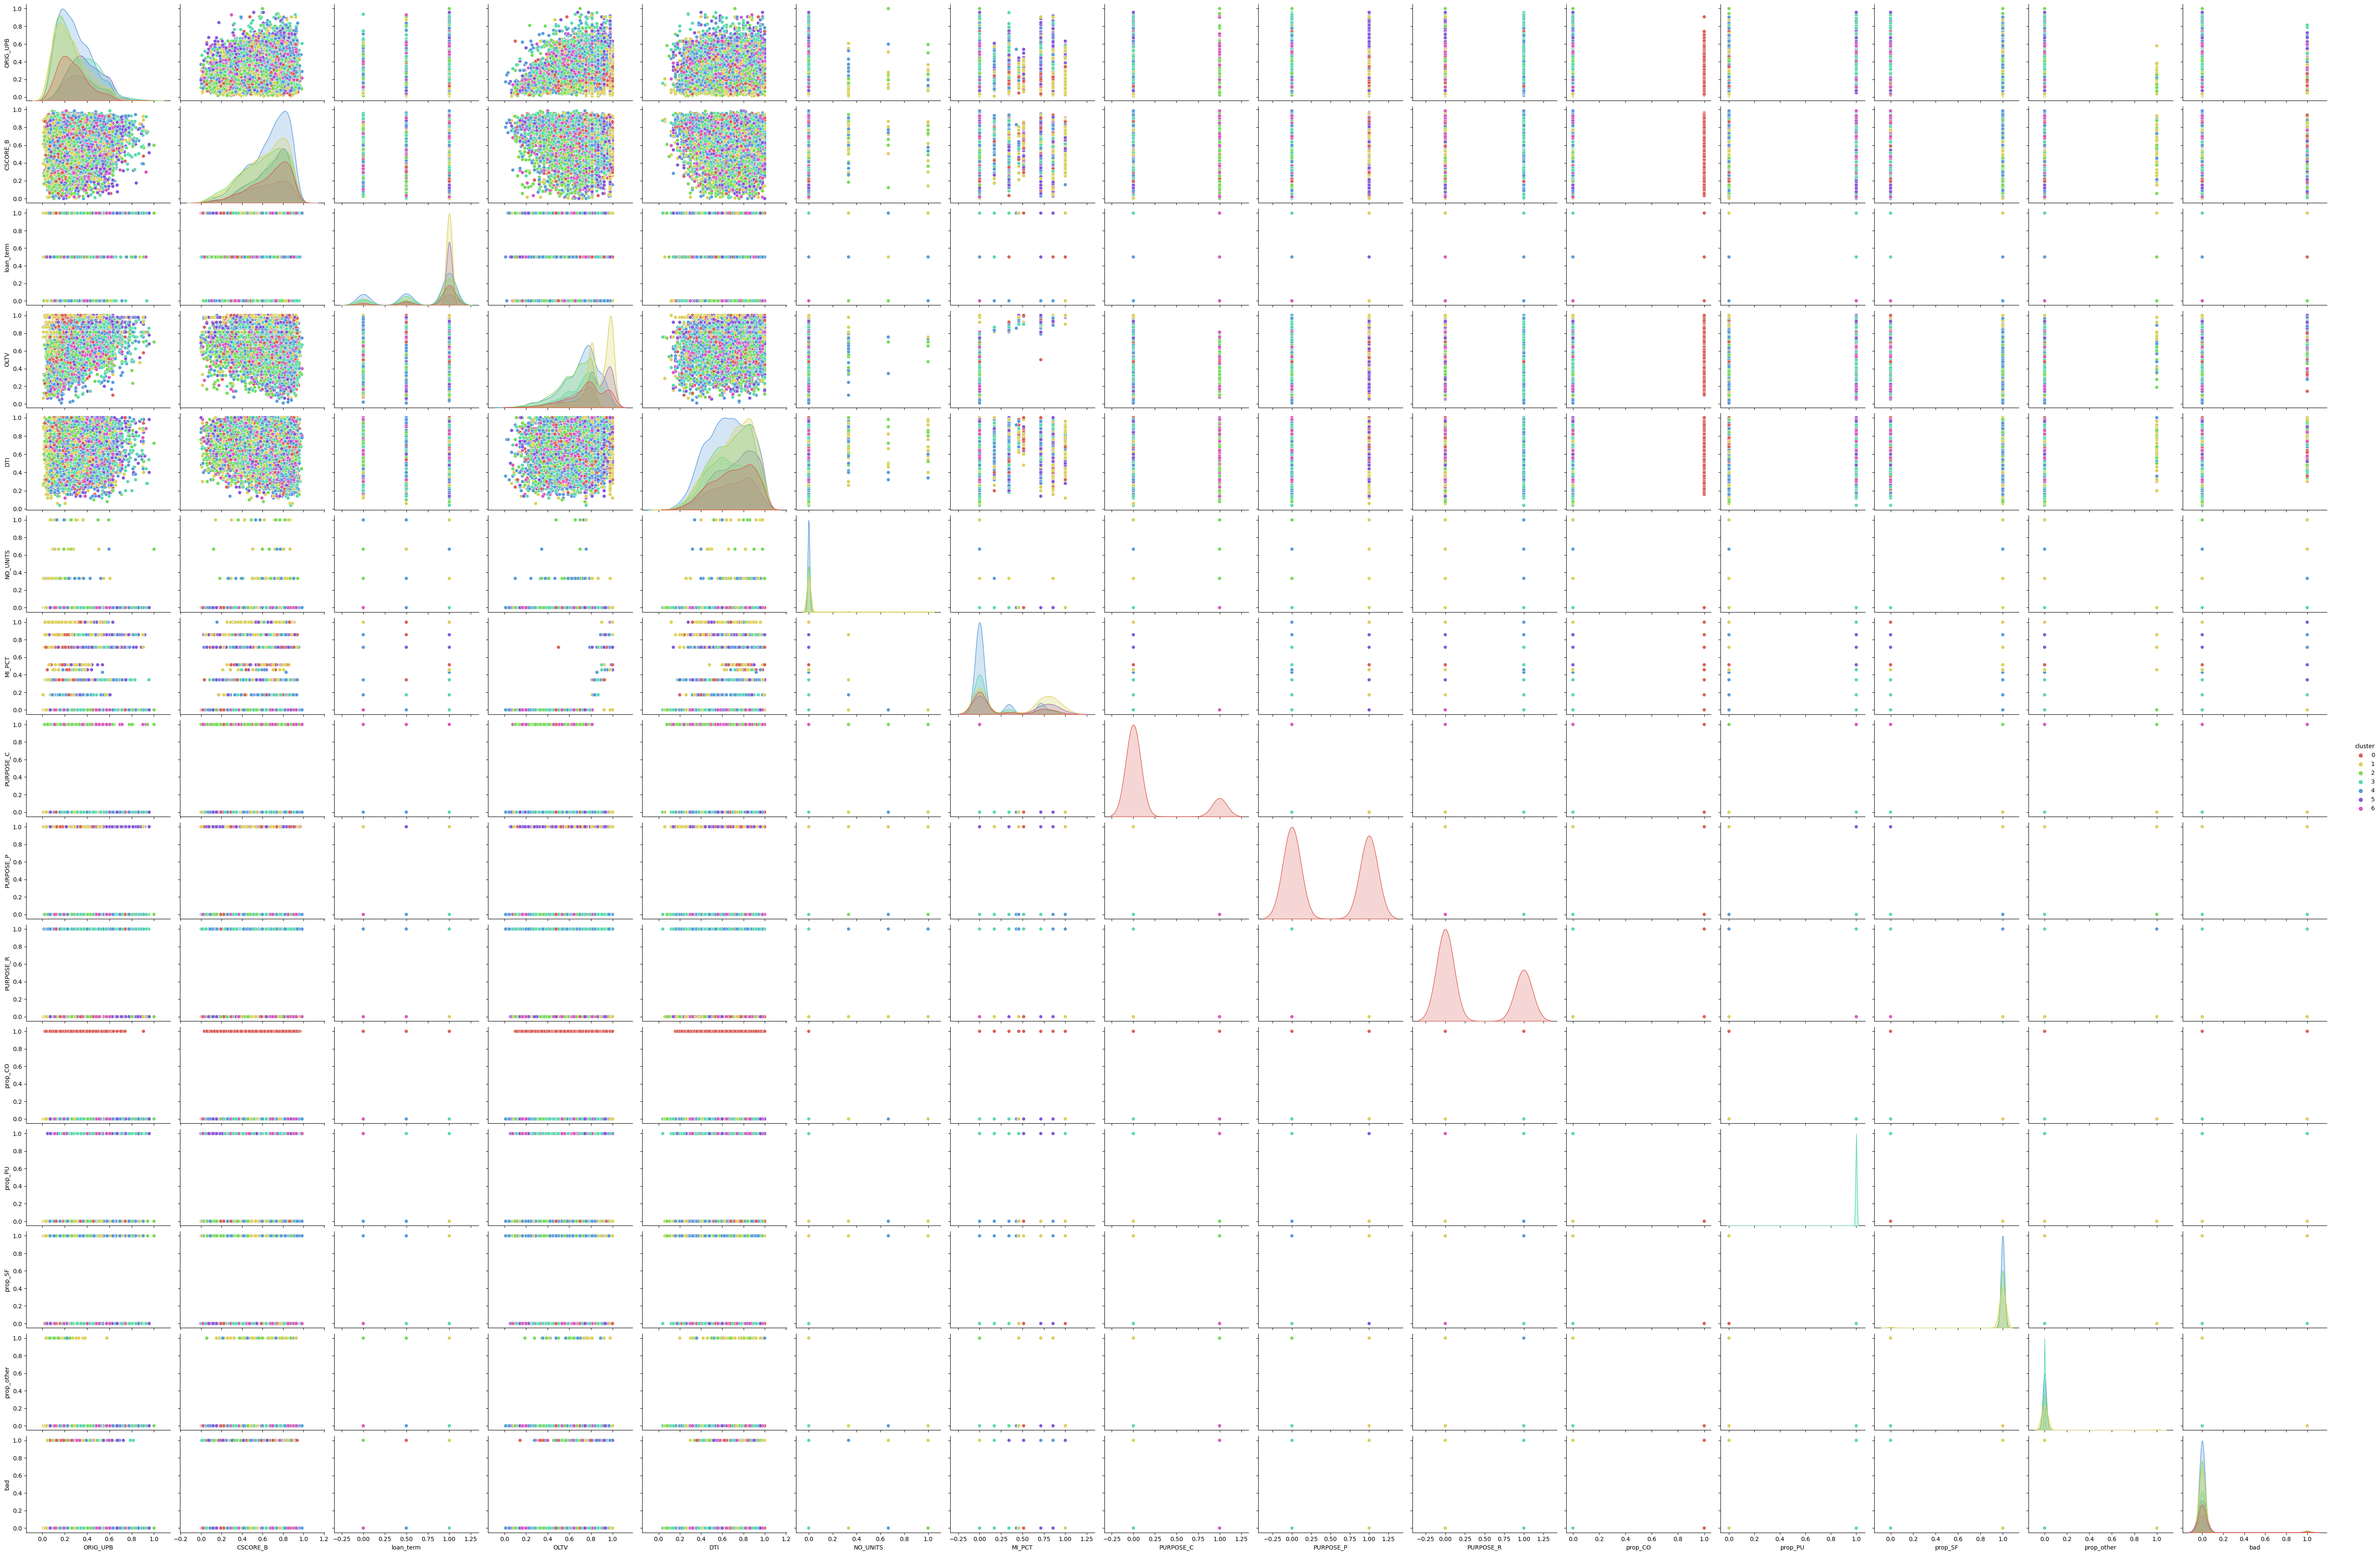

In [49]:
# as the following program is likely to take a long time to run, we make a smaller sample to do it. 
smallsample=modelsample[np.random.uniform(0, 1, len(modelsample['ORIG_UPB'])) < 0.2]
print(smallsample.shape)

sns.pairplot(smallsample, hue='cluster', palette=sns.color_palette('hls', 7), aspect=1.5)

# save the graph to a folder. 
#plt.savefig(path+'project4_segmentation.png', dpi=300)